In [1]:
import numpy as np
import pandas as pd
import matplotlib
import tensorflow as tf
import sklearn

In [2]:
np.__version__, pd.__version__, matplotlib.__version__, tf.__version__, sklearn.__version__

('1.26.4', '2.1.4', '3.7.5', '2.16.1', '1.4.2')

In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Dense, Dropout, LSTM
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

In [4]:
base = pd.read_csv('petr4_treinamento.csv')
base = base.dropna()
base_treinamento = base.iloc[:, 1:7].values

In [5]:
normalizador = MinMaxScaler(feature_range=(0, 1))
base_treinamento_normalizada = normalizador.fit_transform(base_treinamento)

In [6]:
normalizador_previsao = MinMaxScaler(feature_range=(0,1))
normalizador_previsao.fit_transform(base_treinamento[:,0:1])

array([[0.76501938],
       [0.7562984 ],
       [0.78149225],
       ...,
       [0.57122093],
       [0.57655039],
       [0.57655039]])

In [7]:
previsores = []
preco_real = []
for i in range(90, 1242):
    previsores.append(base_treinamento_normalizada[i-90:i, 0:6])
    preco_real.append(base_treinamento_normalizada[i, 0])
previsores, preco_real = np.array(previsores), np.array(preco_real)

In [8]:
regressor = Sequential()
regressor.add(InputLayer(shape=(previsores.shape[1], 6)))
regressor.add(LSTM(units=100, return_sequences=True))
regressor.add(Dropout(0.3))

regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.3))

regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.3))

regressor.add(LSTM(units=50))
regressor.add(Dropout(0.3))

regressor.add(Dense(units=1, activation='sigmoid'))

In [9]:
regressor.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])

In [12]:
es = EarlyStopping(monitor='loss', min_delta=1e-10, patience=10, verbose=1)
rlr = ReduceLROnPlateau(monitor='loss', factor=0.2, patience=5, verbose=1)
mcp = ModelCheckpoint(filepath='pesos.keras', monitor='loss', save_best_only=True, verbose=1)

regressor.fit(previsores, preco_real, epochs=100, batch_size=32, callbacks = [es, rlr, mcp])

Epoch 1/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - loss: 0.0271 - mean_absolute_error: 0.1257
Epoch 1: loss improved from inf to 0.01653, saving model to pesos.keras
36/36 ━━━━━━━━━━━━━━━━━━━━ 8s 94ms/step - loss: 0.0268 - mean_absolute_error: 0.1249 - learning_rate: 0.0010
Epoch 2/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 0.0055 - mean_absolute_error: 0.0589
Epoch 2: loss improved from 0.01653 to 0.00571, saving model to pesos.keras
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 84ms/step - loss: 0.0055 - mean_absolute_error: 0.0589 - learning_rate: 0.0010
Epoch 3/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 0.0059 - mean_absolute_error: 0.0603
Epoch 3: loss improved from 0.00571 to 0.00494, saving model to pesos.keras
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.0058 - mean_absolute_error: 0.0602 - learning_rate: 0.0010
Epoch 4/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - loss: 0.0040 - mean_absolute_error: 0.0497
Epoch 4: loss improved from 0.00494 to 0.00385, saving model 

In [13]:
base_teste = pd.read_csv('petr4_teste.csv')
preco_real_teste = base_teste.iloc[:, 1:2].values
frames = [base, base_teste]
base_completa = pd.concat(frames)
base_completa = base_completa.drop('Date', axis = 1)

In [15]:
entradas = base_completa[len(base_completa) - len(base_teste) - 90:].values
entradas = normalizador.transform(entradas)

In [16]:
X_teste = []
for i in range(90, 112):
    X_teste.append(entradas[i-90:i, 0:6])
X_teste = np.array(X_teste)

In [18]:
previsoes = regressor.predict(X_teste)
previsoes = normalizador_previsao.inverse_transform(previsoes)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


In [19]:
previsoes.mean()
preco_real_teste.mean()

17.87454563636364

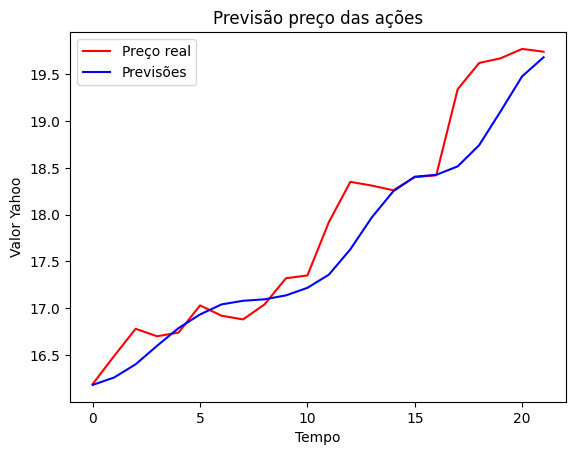

In [20]:
plt.plot(preco_real_teste, color = 'red', label = 'Preço real')
plt.plot(previsoes, color = 'blue', label = 'Previsões')
plt.title('Previsão preço das ações')
plt.xlabel('Tempo')
plt.ylabel('Valor Yahoo')
plt.legend()
plt.show()